## Load Coil20 data
## Extract DSIFT features

In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd("./SSC_ADMM_v1.1")

'C:\\Users\\aleks_000\\Desktop\\Mentorship\\!GitHub'

In [104]:
savemat('./saved/raw/Coil20.mat', mdict={'X':images_raw, 'Y':labels})
savemat('./saved/processed/Coil20.mat', mdict={'X':images_norm, 'Y':labels})

In [100]:
from load import load_Coil20
from img2matrix import single_img2dsift

# I renamed files 1, 2.. to 01, 02..
# so that they are in order here
images_raw, labels = load_Coil20()
images_dsift = [single_img2dsift(image) for image in images_raw]


Loading Coil20...
----------------
Elapsed: 3.34 sec


In [7]:
from scipy.io import loadmat

data = loadmat("../2-DSCN/Data/COIL20.mat")
images_compressed = data['fea']
labels_compressed = data['gnd']

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].imshow(images_raw[0].reshape((-1, 128)));
ax[1].imshow(images_dsift[0].reshape((-1, 128)));

In [ ]:
import numpy as np

fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.mean(images_raw, axis=0).reshape((-1, 128)));
ax[1].imshow(np.mean(images_dsift, axis=0).reshape((-1, 128)));

In [ ]:
fig, ax = plt.subplots(1, 2)
idx = 0

ax[0].imshow(np.mean(images_raw[72*idx:72*(idx+1)], axis=0).reshape((-1, 128)));
ax[1].imshow(np.mean(images_dsift[72*idx:72*(idx+1)], axis=0).reshape((-1, 128)));

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.std(images_raw, axis=0).reshape((-1, 128)));
ax[1].imshow(np.std(images_dsift, axis=0).reshape((-1, 128)));

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images_compressed[0].reshape((-1, 32)));

In [14]:
from visualize import tSNE_2D, tSNE_3D

In [ ]:
#images_raw_flat = images_raw.reshape(images_raw.shape[0], -1)
tSNE_2D(images_compressed, labels_compressed)
tSNE_3D(images_compressed, labels_compressed)

In [ ]:
tSNE_2D(images_dsift, labels)
tSNE_3D(images_dsift, labels)

## Perform PCA

In [105]:
from sklearn.decomposition import PCA
import numpy as np
    
pca = PCA(n_components=1000, whiten=False, svd_solver='arpack', random_state=0)
images_pca = pca.fit_transform(images_raw.reshape(-1, 128*128))
#OR
#images_pca = pca.fit_transform(images_compressed)
#labels = labels_compressed[:, 0]

images_pca.shape

(1440, 1000)

In [106]:
import matplotlib.pyplot as plt

def display_image(image, height, width):
    print(np.min(image), np.max(image))
    imgplot = plt.imshow(image.reshape((height, width)))

In [ ]:
# these are reduced parameters - not supposed to look like anything
display_image(images_pca[0], 20, 50)

In [ ]:
display_image(np.mean(images_pca, axis=0), 20, 50)

In [ ]:
display_image(np.std(images_pca, axis=0), 20, 50)

In [ ]:
tSNE_2D(images_pca, labels)
tSNE_3D(images_pca, labels)

## Normalize PCA output

In [110]:
# Types:
# feature-wise - normalization occurs along one pixel of all images
# image-wise - normalization occurs along all pixels of one image
# all - normalization occurs along all pixels of all images

# Methods:
# standard - mean is set to 0, std is set to 1
# [-1, 1] - min and max are used to linearly change the data range to [-1, 1]
# unit-vector - each bin is divided by its euclidean distance

#[BAD] feature, standard
#images_norm = (images_pca - np.mean(images_pca, axis=0)) / np.std(images_pca, axis=0)
# image, standard
#images_norm = (images_pca - np.mean(images_pca, axis=1)[:, np.newaxis]) / np.std(images_pca, axis=1)[:, np.newaxis]
# all, standard
#images_norm = (images_pca - np.mean(images_pca)) / np.std(images_pca)


#[BAD] feature, [-1, 1]
#mmin = np.min(images_pca, axis=0)
#mmax = np.max(images_pca, axis=0)
#[BAD] image, [-1, 1]
#mmin = np.min(images_pca, axis=1)[:, np.newaxis]
#mmax = np.max(images_pca, axis=1)[:, np.newaxis]
# all, [-1, 1]
mmin = np.min(images_pca)
mmax = np.max(images_pca)
# FOR ALL:
images_norm = (2*images_pca - mmax - mmin) / (mmax - mmin)

#[BAD] feature, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca, axis=0))
# image, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca, axis=1))[:, np.newaxis]
# all, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca))

In [ ]:
import matplotlib.pyplot as plt

# these are reduced parameters - not supposed to look like anything
display_image(images_norm[0], 20, 50)

In [ ]:
display_image(np.mean(images_norm, axis=0), 20, 50)

In [ ]:
display_image(np.std(images_norm, axis=0), 20, 50)

In [ ]:
tSNE_2D(images_norm, labels)
tSNE_3D(images_norm, labels)

## Calculate C matrix

In [114]:
import numpy as np
import supporting_files.sda as sda

from supporting_files.helpers import optimize
from scipy.io import savemat, loadmat

In [119]:
# Matlab SSC #1
savemat('./temp.mat', mdict={'X': images_norm})
k = len(np.unique(labels))
alpha = 999999.0
maxIter = 20
eng.SSC_modified(k, 0, False, alpha, False, 1, 1e-20, maxIter, False)
C = loadmat("./temp.mat")['C']

In [ ]:
display_image(C[:110, :110], 110, 110)
print(np.mean(np.square(C)))

In [ ]:
display_image(np.matmul(C, images_norm)[0], 20, 50)
print(np.mean(np.square(images_norm - np.matmul(C, images_norm))))

## Train Autoencoder

In [130]:
import dsc
import importlib
importlib.reload(dsc)

<module 'dsc' from 'C:\\Users\\aleks_000\\Desktop\\Mentorship\\!GitHub\\dsc.py'>

In [156]:
%%time
trainC = False
d = dsc.DeepSubspaceClustering(images_norm, C=None, trainC=trainC, hidden_dims=[500, 300, 500],
                               lambda1=0.01, lambda2=0.01, lambda3=0.1, learning_rate=0.001, weight_init='sda-normal',
                               weight_init_params=[2001, 0.001, images_norm.shape[0], 250],
                               optimizer='Adam', decay='sqrt', sda_optimizer='Adam', sda_decay='sqrt')

Layer 1
1000 -> 500
epoch 0: global loss = 0.13988341391086578
epoch 250: global loss = 0.016793329268693924
epoch 500: global loss = 0.013986914418637753
epoch 750: global loss = 0.012546186335384846
epoch 1000: global loss = 0.011596109718084335
epoch 1250: global loss = 0.010880017653107643
epoch 1500: global loss = 0.01030078437179327
epoch 1750: global loss = 0.009813454002141953
epoch 2000: global loss = 0.00939276535063982
Layer 2
500 -> 300
epoch 0: global loss = 0.13428202271461487
epoch 250: global loss = 0.018746161833405495
epoch 500: global loss = 0.01532758492976427
epoch 750: global loss = 0.013631063513457775
epoch 1000: global loss = 0.01253791805356741
epoch 1250: global loss = 0.011732731014490128
epoch 1500: global loss = 0.011092832311987877
epoch 1750: global loss = 0.010560164228081703
epoch 2000: global loss = 0.01010299101471901
Wall time: 14min 44s


In [160]:
%%time
d.optimizer = optimize(d.cost, 0.0001, 'Adam', 'sqrt', d.global_step)
d.train(batch_size=images_norm.shape[0], epochs=501, print_step=50)
images_HM2 = d.result
images_HM = d.reconstr
trained_C = np.float64(d.outC)
#best: 0.0001 - 0.000211


epoch 0: global loss = 0.0008602081215940416
epoch 50: global loss = 0.0002214441483374685
epoch 100: global loss = 0.00021768378792330623
epoch 150: global loss = 0.00021581639884971082
epoch 200: global loss = 0.00021458094124682248
epoch 250: global loss = 0.00021368687157519162
epoch 300: global loss = 0.000212992075830698
epoch 350: global loss = 0.00021242139337118715
epoch 400: global loss = 0.00021193087741266936
epoch 450: global loss = 0.0002114944509230554
epoch 500: global loss = 0.00021109788212925196
Wall time: 5min 22s


In [ ]:
# lambda3 - regularization on trained_C
display_image(trained_C[:100, :100], 100, 100)

In [ ]:
display_image(images_HM2[0], 15, 20)

In [ ]:
# lambda1 - self-expressiveness
display_image(np.matmul(trained_C, images_HM2)[0], 10, 15)
print(np.mean(np.square(images_HM2 - np.matmul(trained_C, images_HM2))))

In [ ]:
display_image(np.mean(images_HM2, axis=0), 15, 20)

In [ ]:
display_image(np.std(images_HM2, axis=0), 15, 20)

In [ ]:
tSNE_2D(images_HM2, labels)
tSNE_3D(images_HM2, labels)

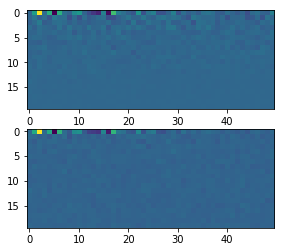

In [164]:
# AE Reconstruction
fig, ax = plt.subplots(2)

index = 0;
ax[0].imshow(images_norm[index].reshape((20, 50)));
ax[1].imshow(images_HM[index].reshape((20, 50)));

In [175]:
reconstr = pca.inverse_transform(((images_HM * (mmax - mmin)) + mmax + mmin) / 2)
pca_reconstr = pca.inverse_transform(((images_norm * (mmax - mmin)) + mmax + mmin) / 2)

In [305]:
from scipy.io import savemat

images_raw_duck = images_raw[720:792]
images_HM2_duck = images_HM2[720:792]
reconstr_duck = reconstr[720:792]
pca_duck = images_norm[720:792]
pca_reconstr_duck = pca_reconstr[720:792]
savemat("../!Important/figures/AE_big", mdict={'H0': images_raw_duck, 'HM2': images_HM2_duck, 'HM': reconstr_duck,
                                               'PCA': pca_duck, 'PCAr': pca_reconstr_duck})

In [326]:
from scipy.io import loadmat

data = loadmat("../!Important/figures/AE_big")
images_raw_duck = data['H0']
images_HM2_duck = data['HM2']
reconstr_duck = data['HM']
pca_duck = data['PCA']
pca_reconstr_duck = data['PCAr']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)

ax[0].imshow(images_raw_duck[0].reshape((-1, 128)));
ax[1].imshow(pca_reconstr_duck[0].reshape((-1, 128)));
ax[2].imshow(reconstr_duck[0].reshape((-1, 128)));

In [328]:
import cv2

def scale(images, scale):
    scaled = np.zeros((images.shape[0], scale*images.shape[1], scale*images.shape[2]), dtype=images.dtype)
    for i in range(images.shape[0]):
        scaled[i] = cv2.resize(images[i], (scale*images.shape[2], scale*images.shape[1]), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
    return scaled

In [329]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

inferno = plt.get_cmap('inferno')

def transform(images, x, y, flip=False, scale=1):
    if flip:
        string = 'ilkj->ijkl'
        shape = (-1, x, y, 4)
    else:
        string = 'iklj->ijkl'
        shape = (-1, y, x, 4)
    cNorm  = colors.Normalize(vmin=np.min(images)/scale, vmax=np.max(images)/scale)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=inferno)
    return np.einsum(string, 256*scalarMap.to_rgba(images.reshape(-1, x*y)).reshape(shape)[:, :, :, :3]).astype(np.uint8)

In [330]:
from array2gif import write_gif

s = 10
images_HM2_duck_inflated = scale(images_HM2_duck.reshape(-1, 15, 20), s).reshape(-1, 20*15*s*s)

write_gif(transform(images_raw_duck, 128, 128), '../!Important/figures/H0.gif')
write_gif(transform(images_HM2_duck_inflated, 20*s, 15*s, scale=1), '../!Important/figures/HM2.gif')
write_gif(transform(reconstr_duck, 128, 128), '../!Important/figures/HM.gif')

In [55]:
# Matlab SSC #2
k = len(np.unique(labels))
alpha = 20.0
maxIter = 50
if(not trainC):
    savemat('./temp.mat', mdict={'X': images_HM2})
else:
    savemat('./temp.mat', mdict={'C': trained_C})
grps = eng.SSC_modified(k, 0, False, alpha, False, 1, 1e-20, maxIter, True, 0, trainC)
C_after = loadmat("./temp.mat")['C']
labels_pred = np.asarray(grps, dtype=np.int32).flatten()

In [ ]:
tSNE_2D(images_HM2, labels_pred)
tSNE_3D(images_HM2, labels_pred)

## Perform clustering with SSC

In [64]:
from supporting_files.ji_zhang import err_rate
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

print("Accuracy: ", str(1-err_rate(labels, labels_pred)))
print("NMI: ", str(nmi(labels, labels_pred, average_method="geometric")))
print("ARI: ", str(ari(labels, labels_pred)))

Accuracy:  0.6659722222222222
NMI:  0.7650959185842292
ARI:  0.5830423165837528


In [116]:
# Python alternative:
from sklearn import cluster

def post_proC(C, K, d, alpha):
    # C: coefficient matrix, K: number of clusters, d: dimension of each subspace
    n = C.shape[0]
    C = 0.5*(C + C.T)
    C = C - np.diag(np.diag(C)) + np.eye(n,n) # for sparse C, this step will make the algorithm more numerically stable
    r = d*K + 1
    U, S, _ = svds(C,r,v0 = np.ones(n))
    U = U[:,::-1] 
    S = np.sqrt(S[::-1])
    S = np.diag(S)
    U = U.dot(S)
    U = normalize(U, norm='l2', axis = 1)  
    Z = U.dot(U.T)
    Z = Z * (Z>0)
    L = np.abs(Z ** alpha)
    L = L/L.max()
    L = 0.5 * (L + L.T)
    spectral = cluster.SpectralClustering(n_clusters=K, eigen_solver='arpack', affinity='precomputed', assign_labels='discretize')
    spectral.fit(L)
    grp = spectral.fit_predict(L) + 1
    return grp, L

def best_map(L1,L2):
    #L1 should be the labels and L2 should be the clustering number we got
    Label1 = np.unique(L1)
    nClass1 = len(Label1)
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2

In [ ]:
labels_pred2 = best_map(post_proC(C_after, k, 0, alpha)[0], labels)